# Tutorial for loading data to train SuperRetina

## Environment
+ Ubuntu 18.04.5 LTS
+ Python 3.8.8
+ conda install pytorch==1.8.1 torchvision==0.9.1 -c pytorch
+ See requirements.txt for other python packages

In [1]:
import os
os.chdir("..")

import configparser
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from torch.utils.data import DataLoader

from common.train_util import train_model
from dataset.retina_dataset import RetinaDataset
from model.super_retina import SuperRetina
import torch.optim as optim
import yaml
from torch.optim import lr_scheduler
import warnings
warnings.filterwarnings('ignore')

## Lab dataset config

In [9]:
config_path = './config/train.yaml'

if os.path.exists(config_path):
    with open(config_path) as f:
        config = yaml.safe_load(f)
else:
    raise FileNotFoundError("Config File doesn't Exist")
    
assert 'MODEL' in config
assert 'PKE' in config
assert 'DATASET' in config
assert 'VALUE_MAP' in config
train_config = {**config['MODEL'], **config['PKE'], **config['DATASET'], **config['VALUE_MAP']}

data_path = train_config['dataset_path']
data_shape = (train_config['model_image_height'], train_config['model_image_width'])

train_split_file = train_config['train_split_file']
val_split_file = train_config['val_split_file']
auxiliary = train_config['auxiliary']

image_path = os.path.join(data_path, 'ImageData')
label_path = os.path.join(data_path, 'Annotations')
train_split_file = os.path.join(data_path, 'ImageSets', train_split_file)
val_split_file = os.path.join(data_path, 'ImageSets', val_split_file)

print(f'The image will resize to {data_shape}')

print(f'The image dir is {image_path}')
print(f'The annotation dir is {label_path}')
print(f'The train index file is {train_split_file}')
print(f'The evaluation index file is {val_split_file}')
print(f'The auxiliary dir is {auxiliary}')


The image will resize to (768, 768)
The image dir is ./data/Lab/ImageData
The annotation dir is ./data/Lab/Annotations
The train index file is ./data/Lab/ImageSets/eccv22_train.txt
The evaluation index file is ./data/Lab/ImageSets/eccv22_val.txt
The auxiliary dir is ./data/Auxiliary


## File Format

The training data is organized as follows.
```
Lab/
    Annotations/
        vistel0_left_0.txt
        vistel0_left_1.txt
        ....       
    ImageData/
        vistel0_left_0.jpg
        vistel0_left_1.jpg
        ....     
    ImageSets/
        eccv22_train.txt  
        eccv22_val.txt    
        Lab.txt  
Auxiliary/
    image1.jpg
    image2.jpg
    ...
```

`Lab/Annotations/` dir includes keypoint annotation files which are `.txt` format.

### load the annotations

In [3]:
file = 'vistel0_left_0'

annotation = os.path.join(label_path, file+'.txt')
annotation = np.loadtxt(annotation)
print('position: (x, y), scaled to 0-1')
print(annotation[:10])

annotation[:, 0] *= data_shape[1]
annotation[:, 1] *= data_shape[0]
print('position: (x, y), mapping to the target size')
print(annotation[:10])

position: (x, y), scaled to 0-1
[[0.59570312 0.11523438]
 [0.69726562 0.11914062]
 [0.32226562 0.1328125 ]
 [0.33789062 0.14453125]
 [0.55859375 0.1484375 ]
 [0.64257812 0.15429688]
 [0.59179688 0.15820312]
 [0.4921875  0.16015625]
 [0.59375    0.17382812]
 [0.41015625 0.18164062]]
position: (x, y), mapping to the target size
[[457.5  88.5]
 [535.5  91.5]
 [247.5 102. ]
 [259.5 111. ]
 [429.  114. ]
 [493.5 118.5]
 [454.5 121.5]
 [378.  123. ]
 [456.  133.5]
 [315.  139.5]]


### Show the keypoints

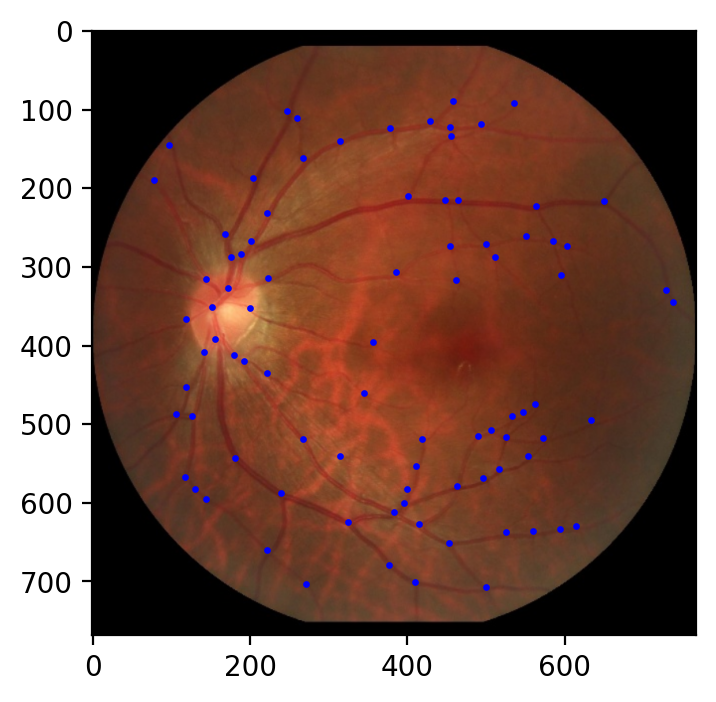

In [4]:
im = cv2.imread(os.path.join(image_path, file+'.jpg'), cv2.IMREAD_COLOR)
im = cv2.resize(im, data_shape)
plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.scatter(annotation[:, 0], annotation[:, 1], s=2, c='b')
plt.show()
plt.close()

### The Format of the Split File 

For example, eccv22_train.txt,

`image_id, label_id`

`image_id` must appear in `ImageData`, and `label_id` must appear in `Annotations`

In [17]:
with open(train_split_file, 'r') as f:
    lines = f.readlines()
lines = [line.replace('\n', '') for line in lines]
print(lines[0])
print(lines[1])

image_id, label_id = lines[0].split(', ')

images = os.listdir(image_path)
labels = os.listdir(label_path)

assert image_id in images and label_id in labels

vistel3_right_1.jpg, vistel3_right_1.txt
vistel16_left_1.jpg, vistel16_left_1.txt


## Create dataset class

In [5]:
data_path = train_config['dataset_path']
data_shape = (train_config['model_image_height'], train_config['model_image_width'])

train_split_file = train_config['train_split_file']
val_split_file = train_config['val_split_file']
auxiliary = train_config['auxiliary']

print('Load Train Data')
train_set = RetinaDataset(data_path, split_file=train_split_file,
                          is_train=True, data_shape=data_shape, auxiliary=auxiliary)

print()
print('Load Eval Data')
val_set = RetinaDataset(data_path, split_file=val_split_file, is_train=False, data_shape=data_shape)

Load Train Data
----------Load Lab data and auxiliary data without labels----------

Load Eval Data
----------Load Lab data, and there is no auxiliary data----------


---
### Using the above datasets, then you can train the SuperRetina